In [1]:
using QuantEcon
using Interpolations
using ConcreteStructs
using Plots, StatsPlots
using Interpolations
using QuantEcon
using Parameters
using Optim
using Optim: minimum, minimizer
using TransformVariables
using FastChebInterp
using DataFrames, DataFramesMeta
using ConcreteStructs
using Roots
using ProgressMeter
using Statistics
using TexTables



# Section B

## Question 1

Part a

$$v(k_0)=\max_{\{c_t, x_{t+1}\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^t u(c_t)$$
$$ \text{s.t } x_{t+1} = 1 +x_t-c_t \text{ for all } t \geq 0 $$
Which can be rewritten as:
$$ v(k) = \max_{c, x'}  u(c) + \beta v(x')$$ 
$$ \text{s.t } x' = 1 +x-c$$

To see why this works, let BC(x) encode the budget constraint set with starting cake x.
$$v(k_0)=\max_{(c_t, x_{t+1})\in BC(x_t)} \sum_{t=0}^{\infty} \beta^t u(c_t)$$
Next we split off $t=0$:
$$=\max_{(c_t, x_{t+1})\in BC(x_t)} u(c_0) + \sum_{t=1}^{\infty} \beta^t u(c_t)$$
Next we factor out $\beta$ and split up the max:
$$=\max_{(c_0, x_1)\in BC(x_0)} u(c_0) + \beta \left( \max_{(c_t, x_{t+1})\in BC(x_t)} \sum_{t=1}^{\infty} \beta^{t-1} u(c_t) \right) $$
Next we reindex the sum:
$$=\max_{(c_0, x_1)\in BC(x_0)} u(c_0) + \beta \left( \max_{(c_t, x_{t+1})\in BC(x_t)}  \sum_{t=0}^{\infty} \beta^{t} u(c_{t+1}) \right) $$
Next we substitute the definition of v back into the equation:
$$=\max_{(c_0, x_1)\in BC(x_0)} u(c_0) + \beta v(x_1) $$
Where we then use the fact that $x_1$ is equivalent to $x'$ which shows x next period.

Part b

In [2]:
function u(p, c)
    @unpack σ = p
    c < 1e-8 && return u(p, 1e-8) - 100 * (c - 1e-8)^2
    return c^(1-σ)/(1-σ)
end

function update_bellman!(p, V, xgrid, V0)
    @unpack β, σ = p
        
    vmax = -Inf
    
    for i in 1:length(xgrid)
        x = xgrid[i]

        xi′ = 0
        ci′ = 0
        
        for j in 1:length(xgrid)
            x′ = xgrid[j]
            c′ = 1 + x - x′
            if c′ >= 0
                v = u(p, c′) + β * V0[j]
                if v >= vmax
                    vmax = v
                    xi′ = xgrid[j]
                    ci′ = c′
            end
        end
    end

        V[i] = vmax  
    end
end

# Implement the VFI algorithm
function solve_vfi(p, xgrid; tol = 1e-6, max_iter = 10000)
    V0 = zeros(length(xgrid))
    V = similar(V0)
    errors = []
    for iter in 1:max_iter
        update_bellman!(p, V, xgrid, V0)
        error = maximum(abs.(V .- V0))
        push!(errors, error)
        if error < tol
            println("Converged after $iter iterations.")
            return V, errors, iter
        end
        copy!(V0, V)
    end
    
    error("Did not converge after $max_iter iterations.")
end

# Parameters
p = (
    β = 0.95,    # Discount Rate
    σ = 2.0,     # Uncertainty aversion
)

(β = 0.95, σ = 2.0)

Converged after 129 iterations.
  0.307256 seconds (125.59 k allocations: 8.841 MiB, 60.11% gc time, 98.33% compilation time)
Converged after 263 iterations.
  0.010351 seconds (685 allocations: 152.477 KiB)
Converged after 1336 iterations.
  0.053102 seconds (2.71 k allocations: 692.188 KiB)


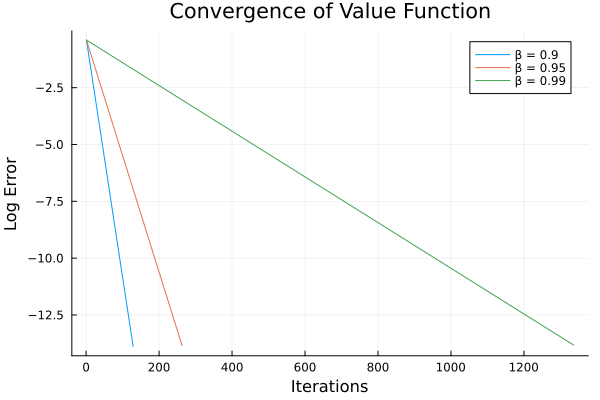

In [3]:

beta_vals = [0.9, 0.95, 0.99]
xgrid = range(1e-4, 10, length = 50)
plot()

for i in 1:3
    p = (
        β = beta_vals[i], 
        σ = 2.5, 
        )


    @time V, errors, iter = solve_vfi(p, xgrid, tol = 1e-6)
    
    # Plot errors for each iteration
    plot!(1:iter, log.(errors), label = "β = $(beta_vals[i])")
end

plot!(legend=:topright, xlabel = "Iterations", ylabel = "Log Error", title = "Convergence of Value Function")

The above graph is not worked out with linear interpolation, it is using a grid search however, I have kept it in to show that the next graph we has been working out with linear interpolation is correct.

In [4]:
function u(p, c)
    @unpack σ = p
    c < 1e-8 && return u(p, 1e-8) - 100 * (c - 1e-8)^2
    return c^(1-σ)/(1-σ)
end

function update_bellman!(p, V, xgrid, V0)
    @unpack β, σ = p
        
    vmax = -Inf

    # Use Linear Interpolation to interpolate continuation value 
    V̂ = linear_interpolation(xgrid, V0, extrapolation_bc=Line())

    c_list = zeros(length(xgrid))
    for i in 1:length(xgrid)
        x = xgrid[i]

        xi′ = 0
        ci = 0
        
        for j in 1:length(xgrid)
            x′ = xgrid[j]
            c = 1 + x - x′
            if c >= 0
                v = u(p, c) + β * V̂(j)
                if v >= vmax
                    vmax = v
                    xi′ = xgrid[j]
                    ci = c
            end
        end
    end
        c_list[i] = ci
        V[i] = vmax  
    end
    return c_list, V
end

# Implement the VFI algorithm
function solve_vfi(p, xgrid; tol = 1e-6, max_iter = 10000)
    V0 = zeros(length(xgrid))
    V = similar(V0)
    errors = []
    for iter in 1:max_iter
        c_list, V = update_bellman!(p, V, xgrid, V0)

        error = maximum(abs.(V .- V0))
        push!(errors, error)
        if error < tol
            println("Converged after $iter iterations.")
            return V, errors, iter, c_list
        end
        copy!(V0, V)
    end
    
    error("Did not converge after $max_iter iterations.")
end

# Parameters
p = (
    β = 0.95,    # Discount Rate
    σ = 2.0,     # Uncertainty aversion
)

(β = 0.95, σ = 2.0)

Converged after 174 iterations.
  0.555383 seconds (591.78 k allocations: 39.647 MiB, 3.70% gc time, 98.35% compilation time)
Converged after 352 iterations.
  0.019833 seconds (1.45 k allocations: 527.023 KiB)
Converged after 1774 iterations.
  0.094917 seconds (7.26 k allocations: 2.579 MiB)


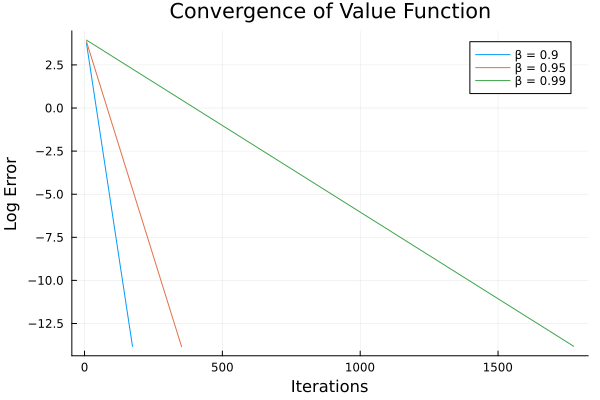

In [5]:

beta_vals = [0.9, 0.95, 0.99]
xgrid = range(1e-4, 10, length = 50)
plot()

for i in 1:3
    p = (
        β = beta_vals[i], 
        σ = 2.5, 
        )


    @time V, errors, iter, c_list = solve_vfi(p, xgrid, tol = 1e-6)

    # Plot errors for each iteration
    plot!(7:iter, log.(errors[7:end]), label = "β = $(beta_vals[i])")
end

plot!(legend=:topright, xlabel = "Iterations", ylabel = "Log Error", title = "Convergence of Value Function")

Part c

Here we dervie the Euler equation for this model.
$$ u(c_t) = \frac{c_t^{1-\sigma}}{1-\sigma}$$
Let $\lambda_t$ be the Lagrange multiplier associated with the budget constraint at each time period $t$.
Combining the utility function, which we want to maximise, with the series of budget constraints yields the following Lagrangian:
$$\ell = \sum_{t=0}^{\infty} \beta^t \frac{c_t^{1-\sigma}}{1-\sigma} + \sum_{t=0}^{\infty} \lambda_t \left[1+x_t-c_t-x_{t+1}\right]$$
Where the choice variables are $c_t$ and $x_{t+1} \forall t \in \{0,1,2,...\}.$ The problem here is "well-behaved" so that the optimum can be found at the point where the derivatives of the Lagrangian with respect to the choices $c_t$ and $x_{t+1}$ are equal to 0: $\frac{d\ell}{d c_t}=0$ and $\frac{d \ell}{d x_{t+1}}=0.$ 

The first-order condition with respect to $c_t$ is $\beta^t (1-\sigma) \frac{c_t^{-\sigma}}{1-\sigma} - \lambda_t= 0$ or simply, $\beta^t c_t^{-\sigma}=\lambda_t.$
The first-order condition with respect to $x_{t+1}$ is $-\lambda_t+\lambda_{t+1}=0$.
Substituting $\lambda_t = \beta^t c_t^{-\sigma}$ and $\lambda_{t+1}=\beta^{t+1} c_{t+1}^{-\sigma}$.
We get $\beta^{t+1} c_{t+1}^{-\sigma} = \beta^t c_t^{-\sigma} \iff c_{t+1}^{\sigma}c_t^{-\sigma}=\beta \iff \left(\frac{c_{t+1}}{c_t}\right)^\sigma = \beta$. This is the Euler equation for our model.


Converged after 174 iterations.
  0.008837 seconds (750 allocations: 260.312 KiB)


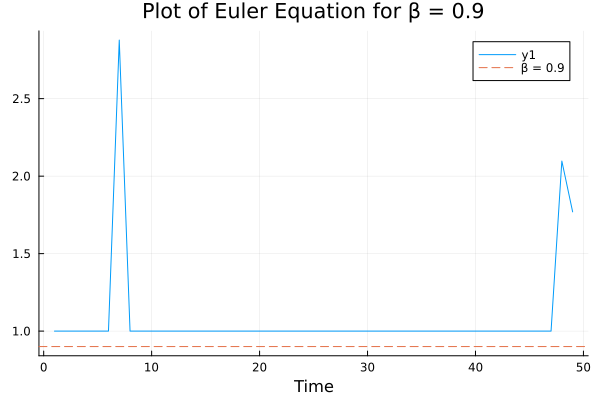

Converged after 352 iterations.
  0.018959 seconds (1.46 k allocations: 527.078 KiB)


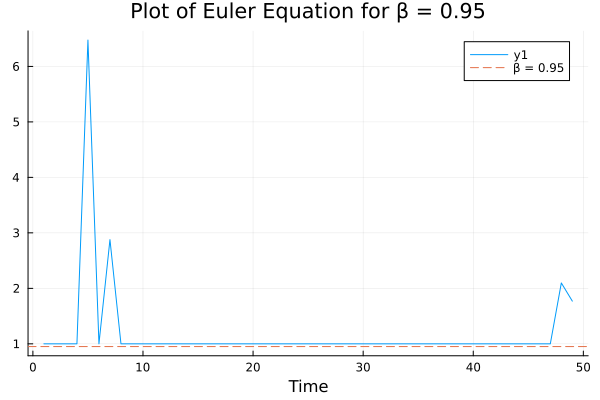

Converged after 1774 iterations.
  0.158963 seconds (7.15 k allocations: 2.568 MiB)


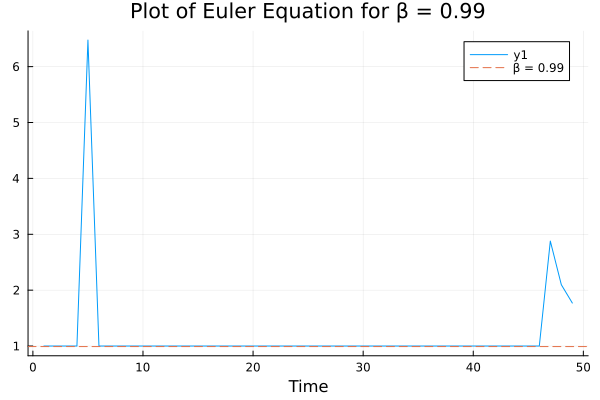

In [12]:
function u_prime(p, c)
    @unpack σ = p
    return c^(-σ)
end

beta_vals = [0.9, 0.95, 0.99]
xgrid = range(1e-4, 10, length = 50)

for (i, beta) in enumerate(beta_vals)
    p = (
        β = beta, 
        σ = 2.5, 
        )
    @time V, errors, iter, c_list = solve_vfi(p, xgrid, tol = 1e-6)
    c_plot = [u_prime(p, c_list[j]) / u_prime(p, c_list[j + 1]) for j in 1:length(c_list)-1]
    # Plot Euler equation differences
    plot(1:length(c_list)-1, c_plot, legend=:topright, xlabel = "Time", ylabel = "", title = "Plot of Euler Equation for β = $beta")
    hline!([beta], label="β = $beta", linestyle=:dash)
    display(plot!())
end


Next we test to see if the Euler equation we previously calculated holds for our values of $\beta$.

Converged after 174 iterations.
  0.009999 seconds (747 allocations: 259.938 KiB)


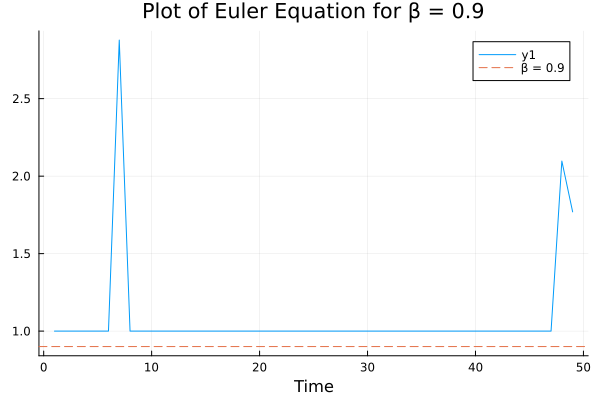

Converged after 352 iterations.
  0.042260 seconds (1.46 k allocations: 527.000 KiB)


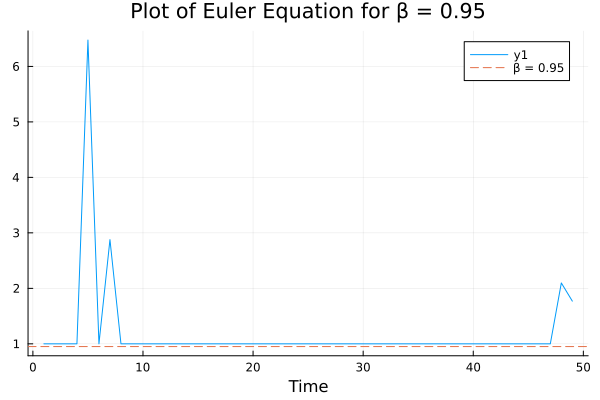

Converged after 1774 iterations.
  0.166023 seconds (7.15 k allocations: 2.568 MiB)


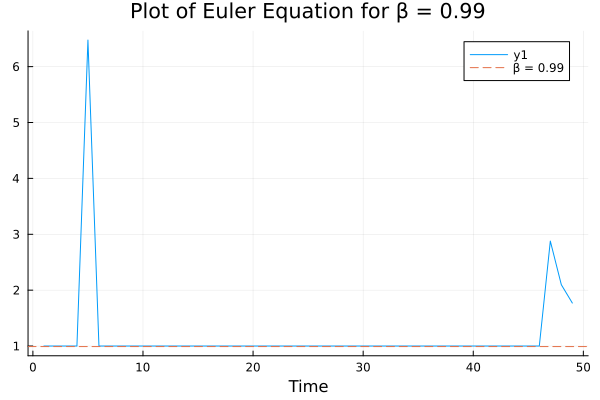

In [15]:
beta_vals = [0.9, 0.95, 0.99]
xgrid = range(1e-4, 10, length = 50)

for (i, beta) in enumerate(beta_vals)
    plot()

    p = (
        β = beta, 
        σ = 2.5, 
        )
    @time V, errors, iter = solve_vfi(p, xgrid, tol = 1e-6)
    c_list, V = update_bellman!(p, V, xgrid, V)
    @unpack σ = p
    c_plot = [(c_list[j + 1] / (c_list[j]))^σ  for j in 1:length(c_list)-1]
    # Plot Euler equation differences
    plot!(1:length(c_list)-1, c_plot)
    plot!(legend=:topright, xlabel = "Time", ylabel = "", title = "Plot of Euler Equation for β = $beta")
    hline!([beta], label="β = $beta", linestyle=:dash)
    display(plot!())
end

The Euler equation does not hold exactly in our numerical solution, 

In order to make sure it holds in our algorithm we could enforce it as a requirements in our constraint. e.g $\frac{c_{t+1}}{c_t} = \beta^{\sigma^{-1}}$